# Generating the Control Set

The **Control Set** is a library of pre-computed motion primitives. Each primitive is a short, kinematically feasible trajectory connecting a discrete start state $(0, 0, \theta_l)$ to a neighbor discrete state.

Here, we use a 16-angle discretization ($l \in \{0, \ldots, 15\}$). The generation process involves:
1.  Selecting a start direction $\theta_l$.
2.  Selecting a target discrete state $(i_f, j_f, \theta_{l_f})$.
3.  Solving the boundary value problem using the Newton's method described earlier.

**Symmetry Optimization:**
To reduce computation time, we exploit the symmetry of the grid. For example, the set of primitives starting from $0^\circ$ is geometrically identical to those starting from $90^\circ$, $180^\circ$, and $270^\circ$, just rotated. We generate the "base" primitives and then replicate them by rotating by $\pi/2$.

### A Note on Coordinate Systems

In this implementation, we work in the standard Cartesian plane where the **x-axis points right** and the **y-axis points up**.

<details>
  <summary><strong>Click here for details on Grid vs. Cartesian coordinates ($i$-axis direction)</strong></summary>

  In many path planning implementations involving grid maps, the coordinate system follows matrix indexing:
  * **$i$-axis (rows):** Points **down**.
  * **$j$-axis (columns):** Points **right**.

  However, our trajectory generation math (cubic polynomials, derivatives) assumes a standard Cartesian system ($y$ points **up**). 
  
  **Does this matter?**
  Mathematically, no. The robot and the algorithm only care about relative changes in coordinates. A "forward-left" turn is valid regardless of which way "up" is defined on the map.
  
  **Visual Interpretation:**
  If you use these primitives on a map where $i$ points down:
  1.  The trajectories are valid and collision checks work (provided you round $x,y$ to $j,i$ consistently).
  2.  **Visual discrepancy:** A primitive with a positive starting angle might appear to move "down" on the screen because the $i$-axis grows downwards.
  
  **Solution:**
  If you strictly require the visual representation to match a specific map orientation (e.g., $i$-down), you can simply flip the **input/output angles** (use $-\theta$ instead of $\theta$) when querying the primitives. The internal geometry of the curve remains the same.
  
  For this notebook and the C++ testing framework, we use the standard mathematical convention ($x$-right, $y$-up).
</details>

In [16]:
import matplotlib.pyplot as plt
from create_prims_file import save_and_show
from trajectory_optimization import optimization_Newton 

import sys
sys.path.append("../common/")
from KC_structs import *
from KC_graphics import *

%matplotlib inline  

In [17]:
theta_16 = Theta()
primitives_file = "add_control_set.txt"

## Cardinal Directions ($0, \pi/2, \pi, 3\pi/2$)

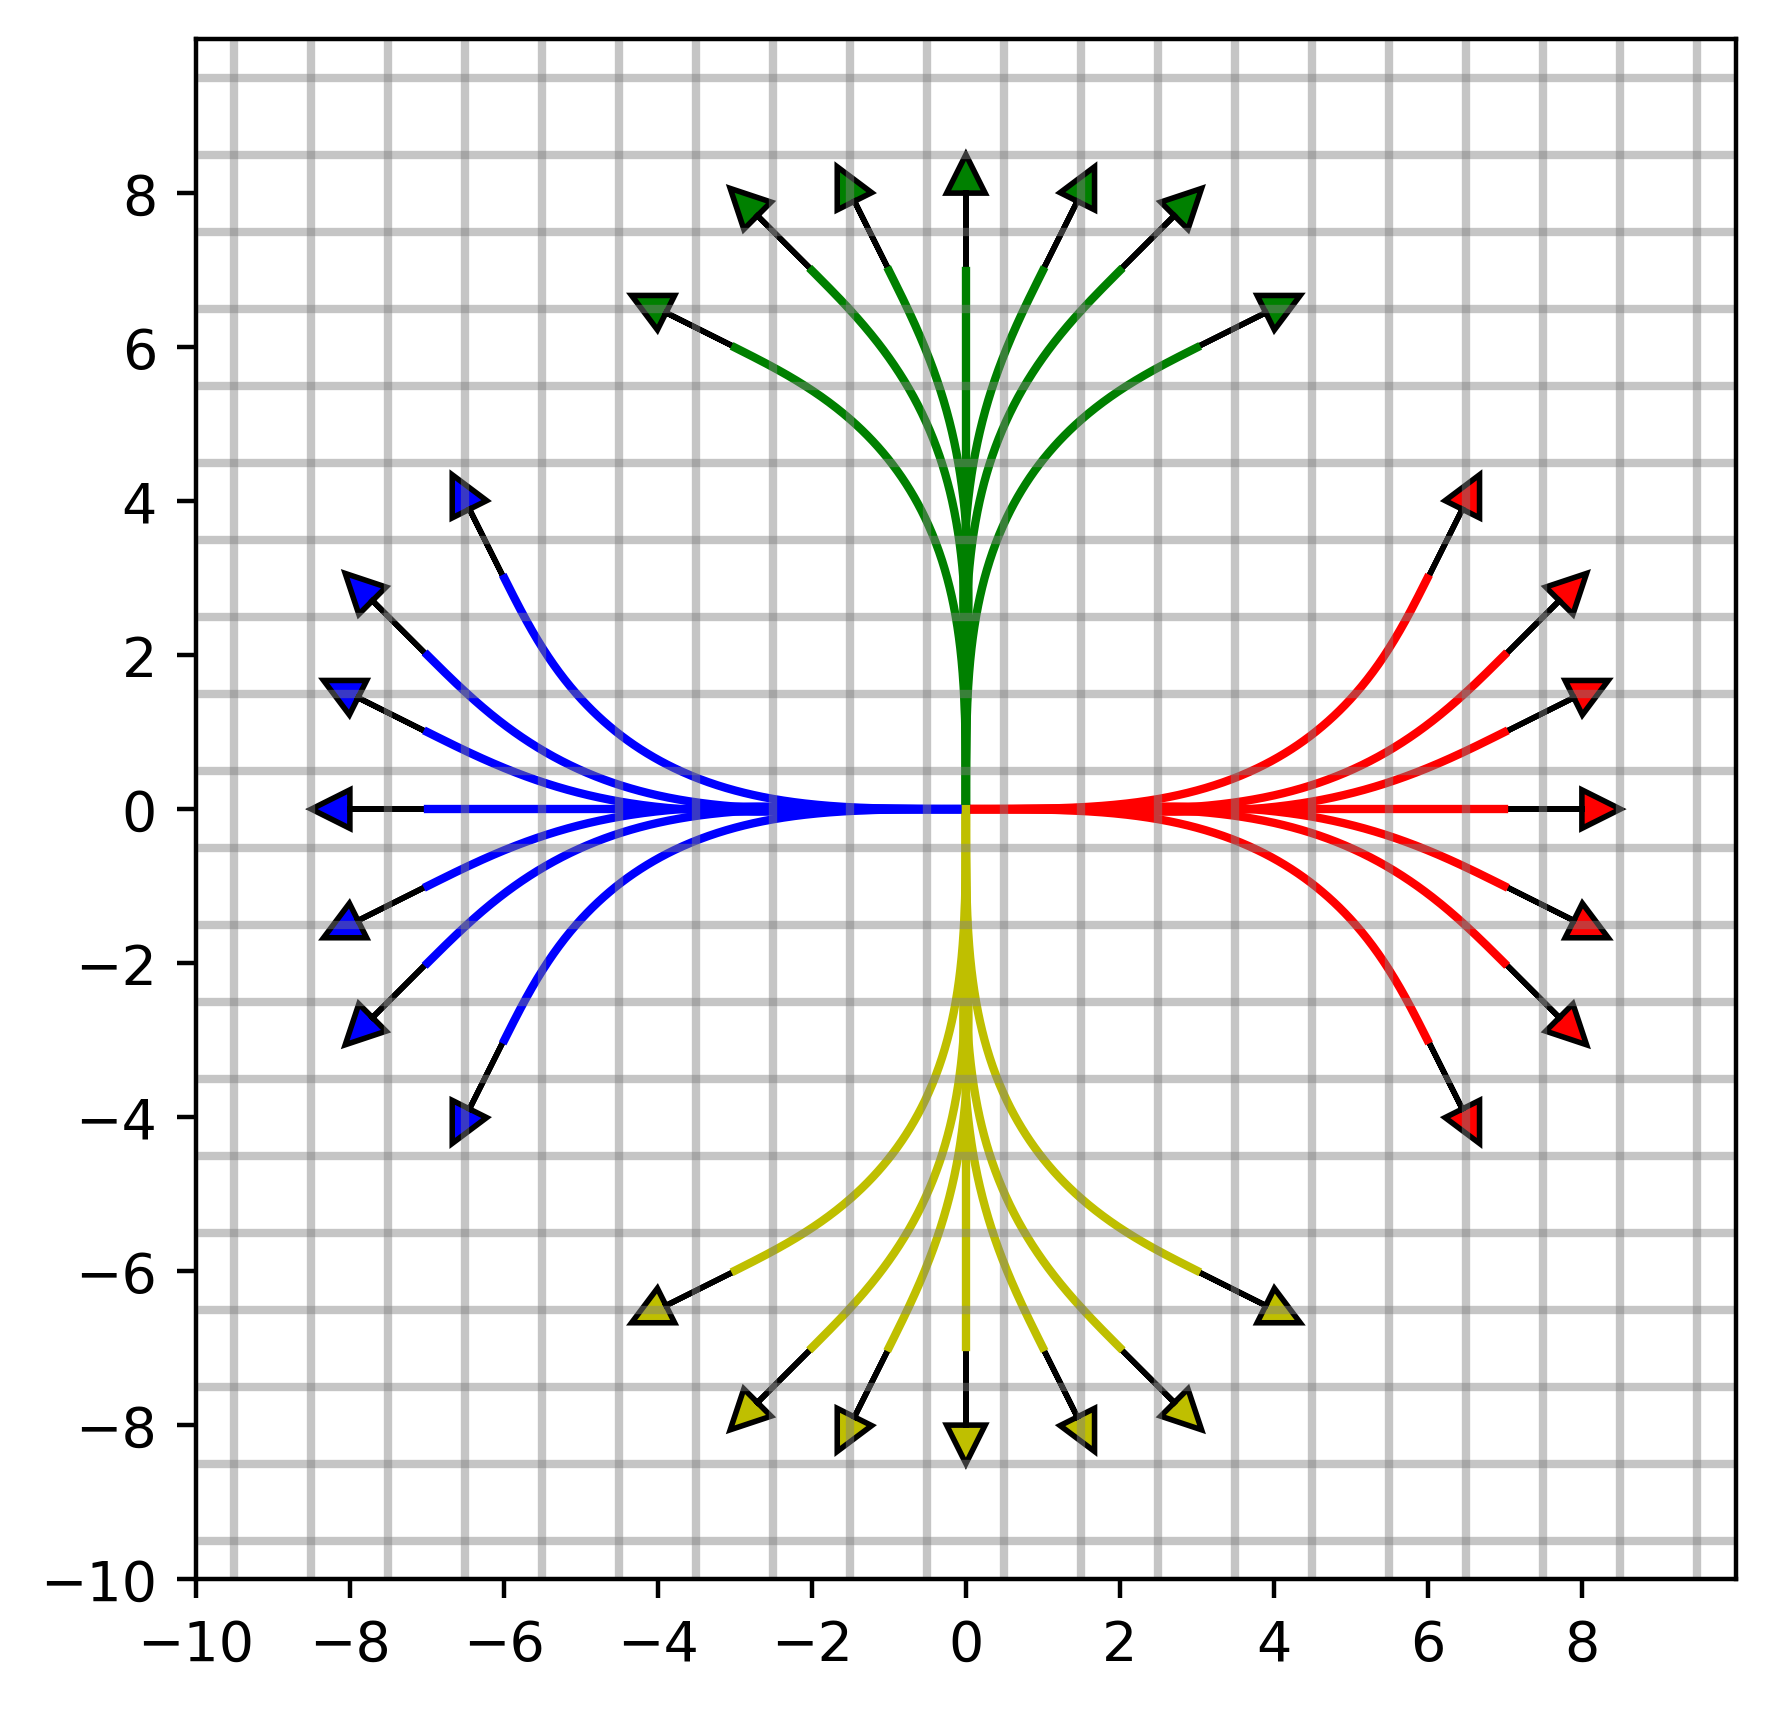

In [18]:
# 1. Generate primitives for Cardinal directions (0, 90, 180, 270 degrees)

# Define start state for angle 0
# We use the State class (continuous) because generation is a continuous optimization problem.
start = State(x=0, y=0, theta=theta_16[0]) 

fig = plt.figure(figsize=(5, 5), dpi=400)
ax = fig.add_subplot(111)
ax.set_aspect('equal', adjustable='box') # Fix aspect ratio

# Define 7 target states relative to the start
targets = [
    State(x=7.0, y=0.0, theta=theta_16[0]),   # Straight
    
    State(x=7.0, y=1.0, theta=theta_16[1]),   # Shallow turn left
    State(x=7.0, y=2.0, theta=theta_16[2]),
    State(x=6.0, y=3.0, theta=theta_16[3]),   # Sharp turn left
    
    State(x=7.0, y=-1.0, theta=theta_16[-1]), # Shallow turn right
    State(x=7.0, y=-2.0, theta=theta_16[-2]),
    State(x=6.0, y=-3.0, theta=theta_16[-3])  # Sharp turn right
]

for target in targets:
    # Generate the primitive
    steps, prim = optimization_Newton(start=start, goal=target)
    
    # Save the primitive and automatically generate/save its 3 rotated copies (90, 180, 270 deg)
    # This results in 7 * 4 = 28 primitives total
    save_and_show(file=primitives_file, prim=prim, ax=ax, theta_discrete=theta_16)

# Draw the grid to visualize the discrete workspace
draw_grid(ax, xs=-10, ys=-10, xf=10, yf=10, tick_step=2)

# plt.savefig("../../images/add_cs0.png", transparent=False, facecolor='white')
plt.show()

## Diagonal Directions ($~\pi/4,~~3\pi/4,~~5\pi/4,~~7\pi/4$)

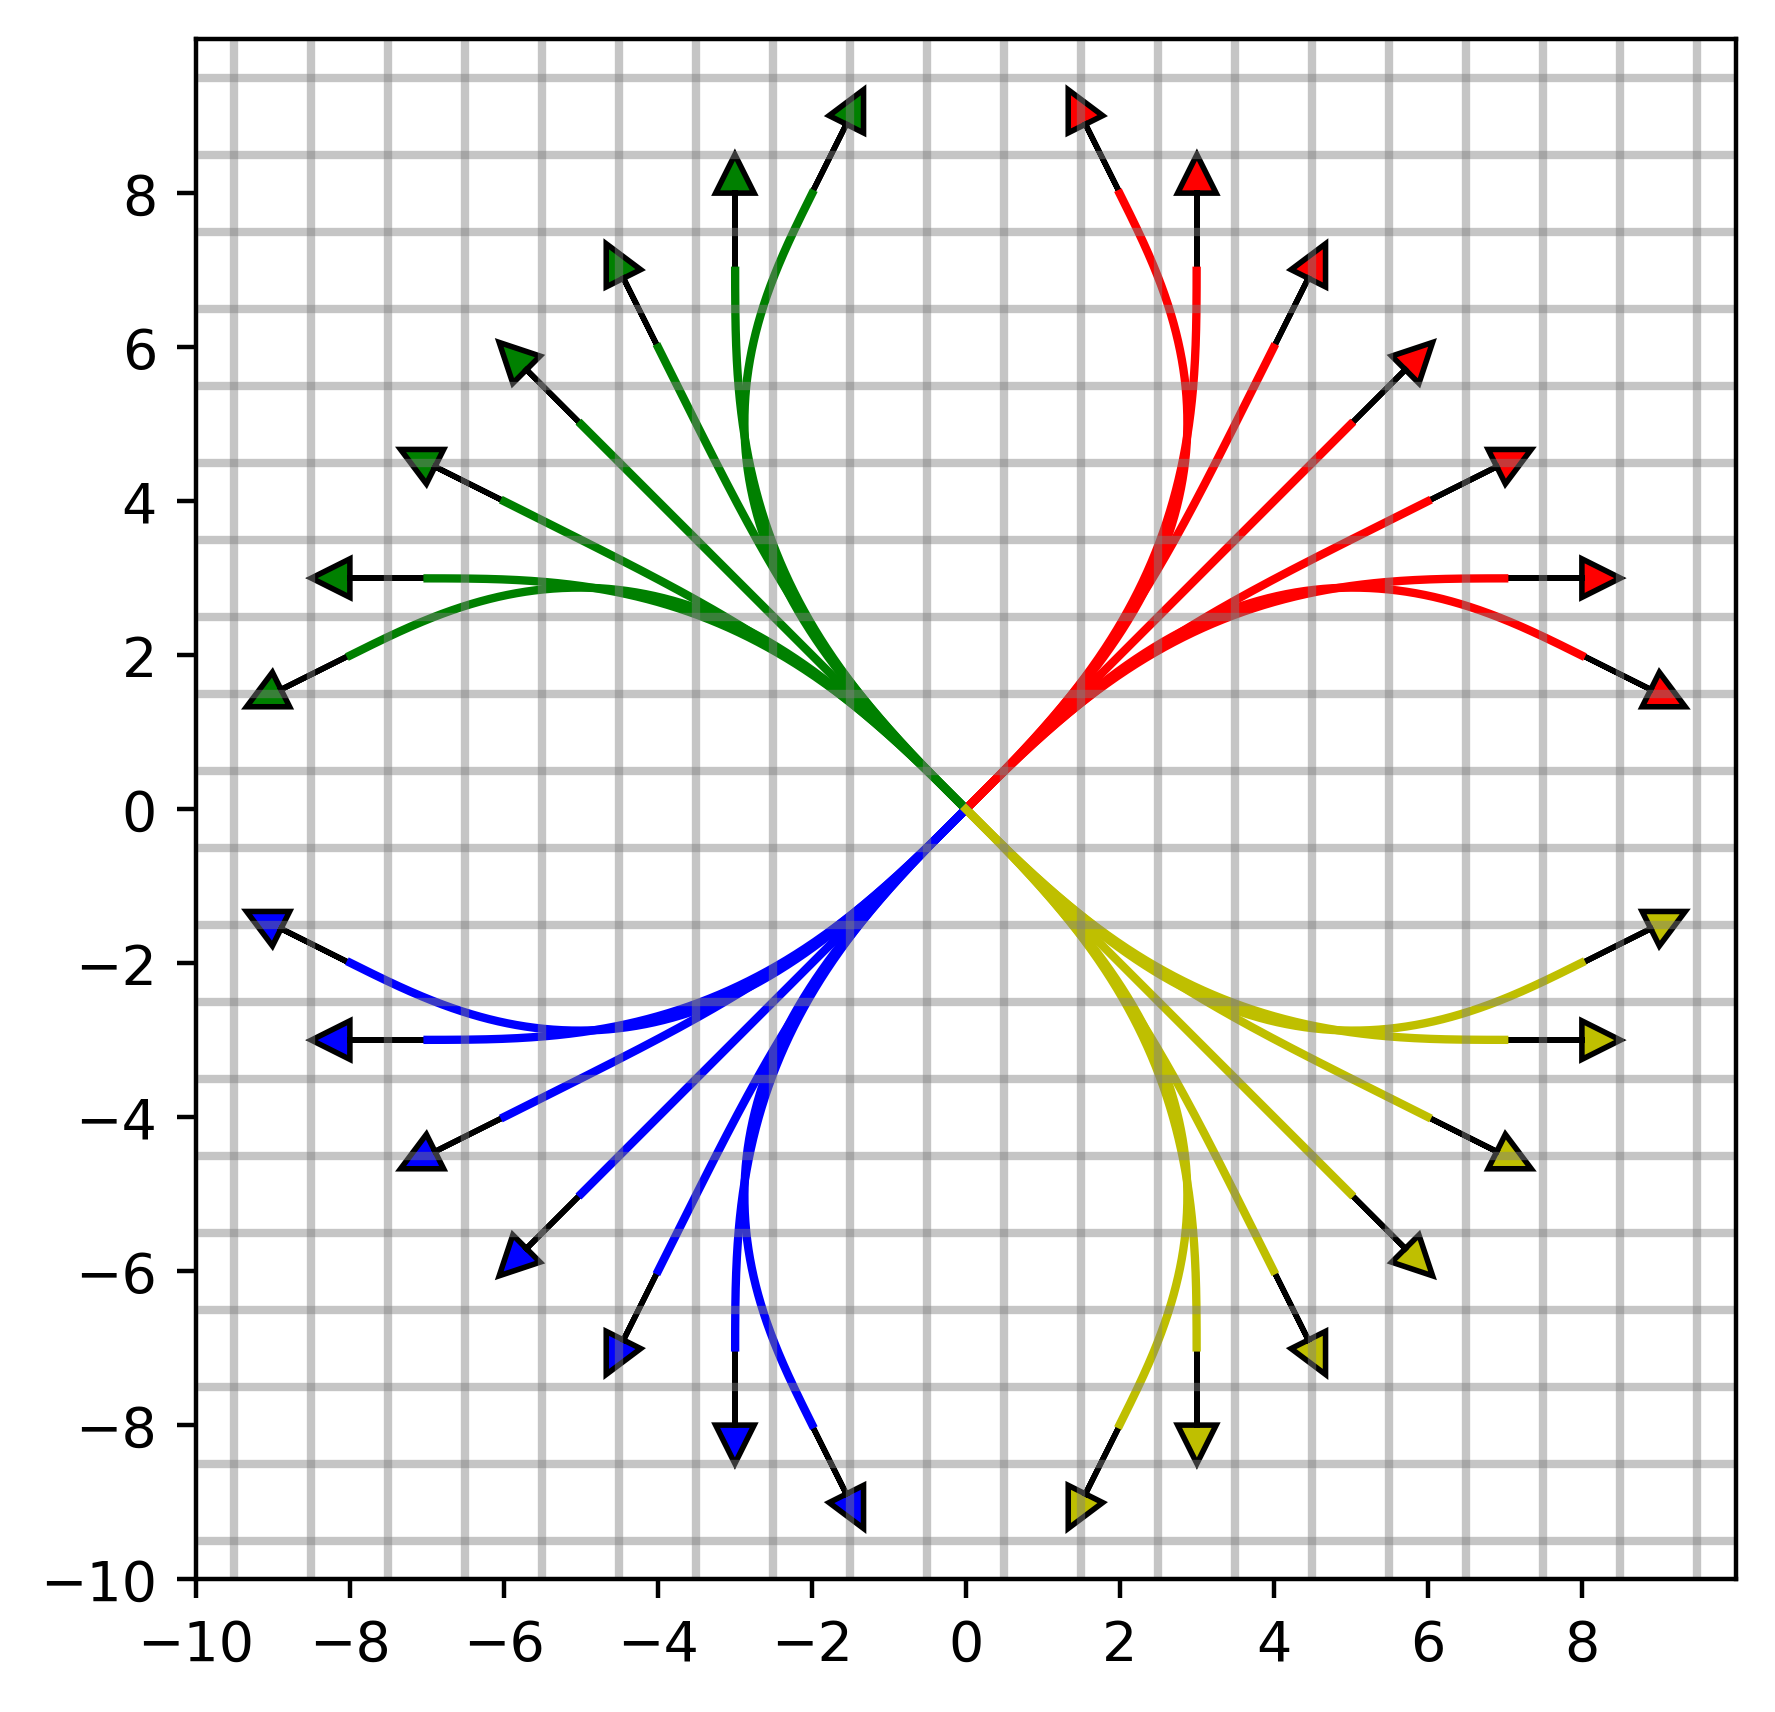

In [19]:
# 2. Generate primitives for Diagonal directions (45, 135, 225, 315 degrees)
# Corresponds to index 2 in our 16-angle discretization

start = State(x=0, y=0, theta=theta_16[2]) 

fig = plt.figure(figsize=(5, 5), dpi=400)
ax = fig.add_subplot(111)
ax.set_aspect('equal', adjustable='box')

targets = [
    State(x=5.0, y=5.0, theta=theta_16[2]),   # Straight diagonal
    
    State(x=6.0, y=4.0, theta=theta_16[1]),
    State(x=7.0, y=3.0, theta=0),
    State(x=8.0, y=2.0, theta=theta_16[-1]),
    
    State(x=4.0, y=6.0, theta=theta_16[3]),
    State(x=3.0, y=7.0, theta=theta_16[4]),
    State(x=2.0, y=8.0, theta=theta_16[5])
]

for target in targets:
    steps, prim = optimization_Newton(start=start, goal=target)
    save_and_show(file=primitives_file, prim=prim, ax=ax, theta_discrete=theta_16)

draw_grid(ax, xs=-10, ys=-10, xf=10, yf=10, tick_step=2)

# plt.savefig("../../images/add_cs1.png", transparent=False, facecolor='white')
plt.show()

## Remaining Directions (Intermediate angles)

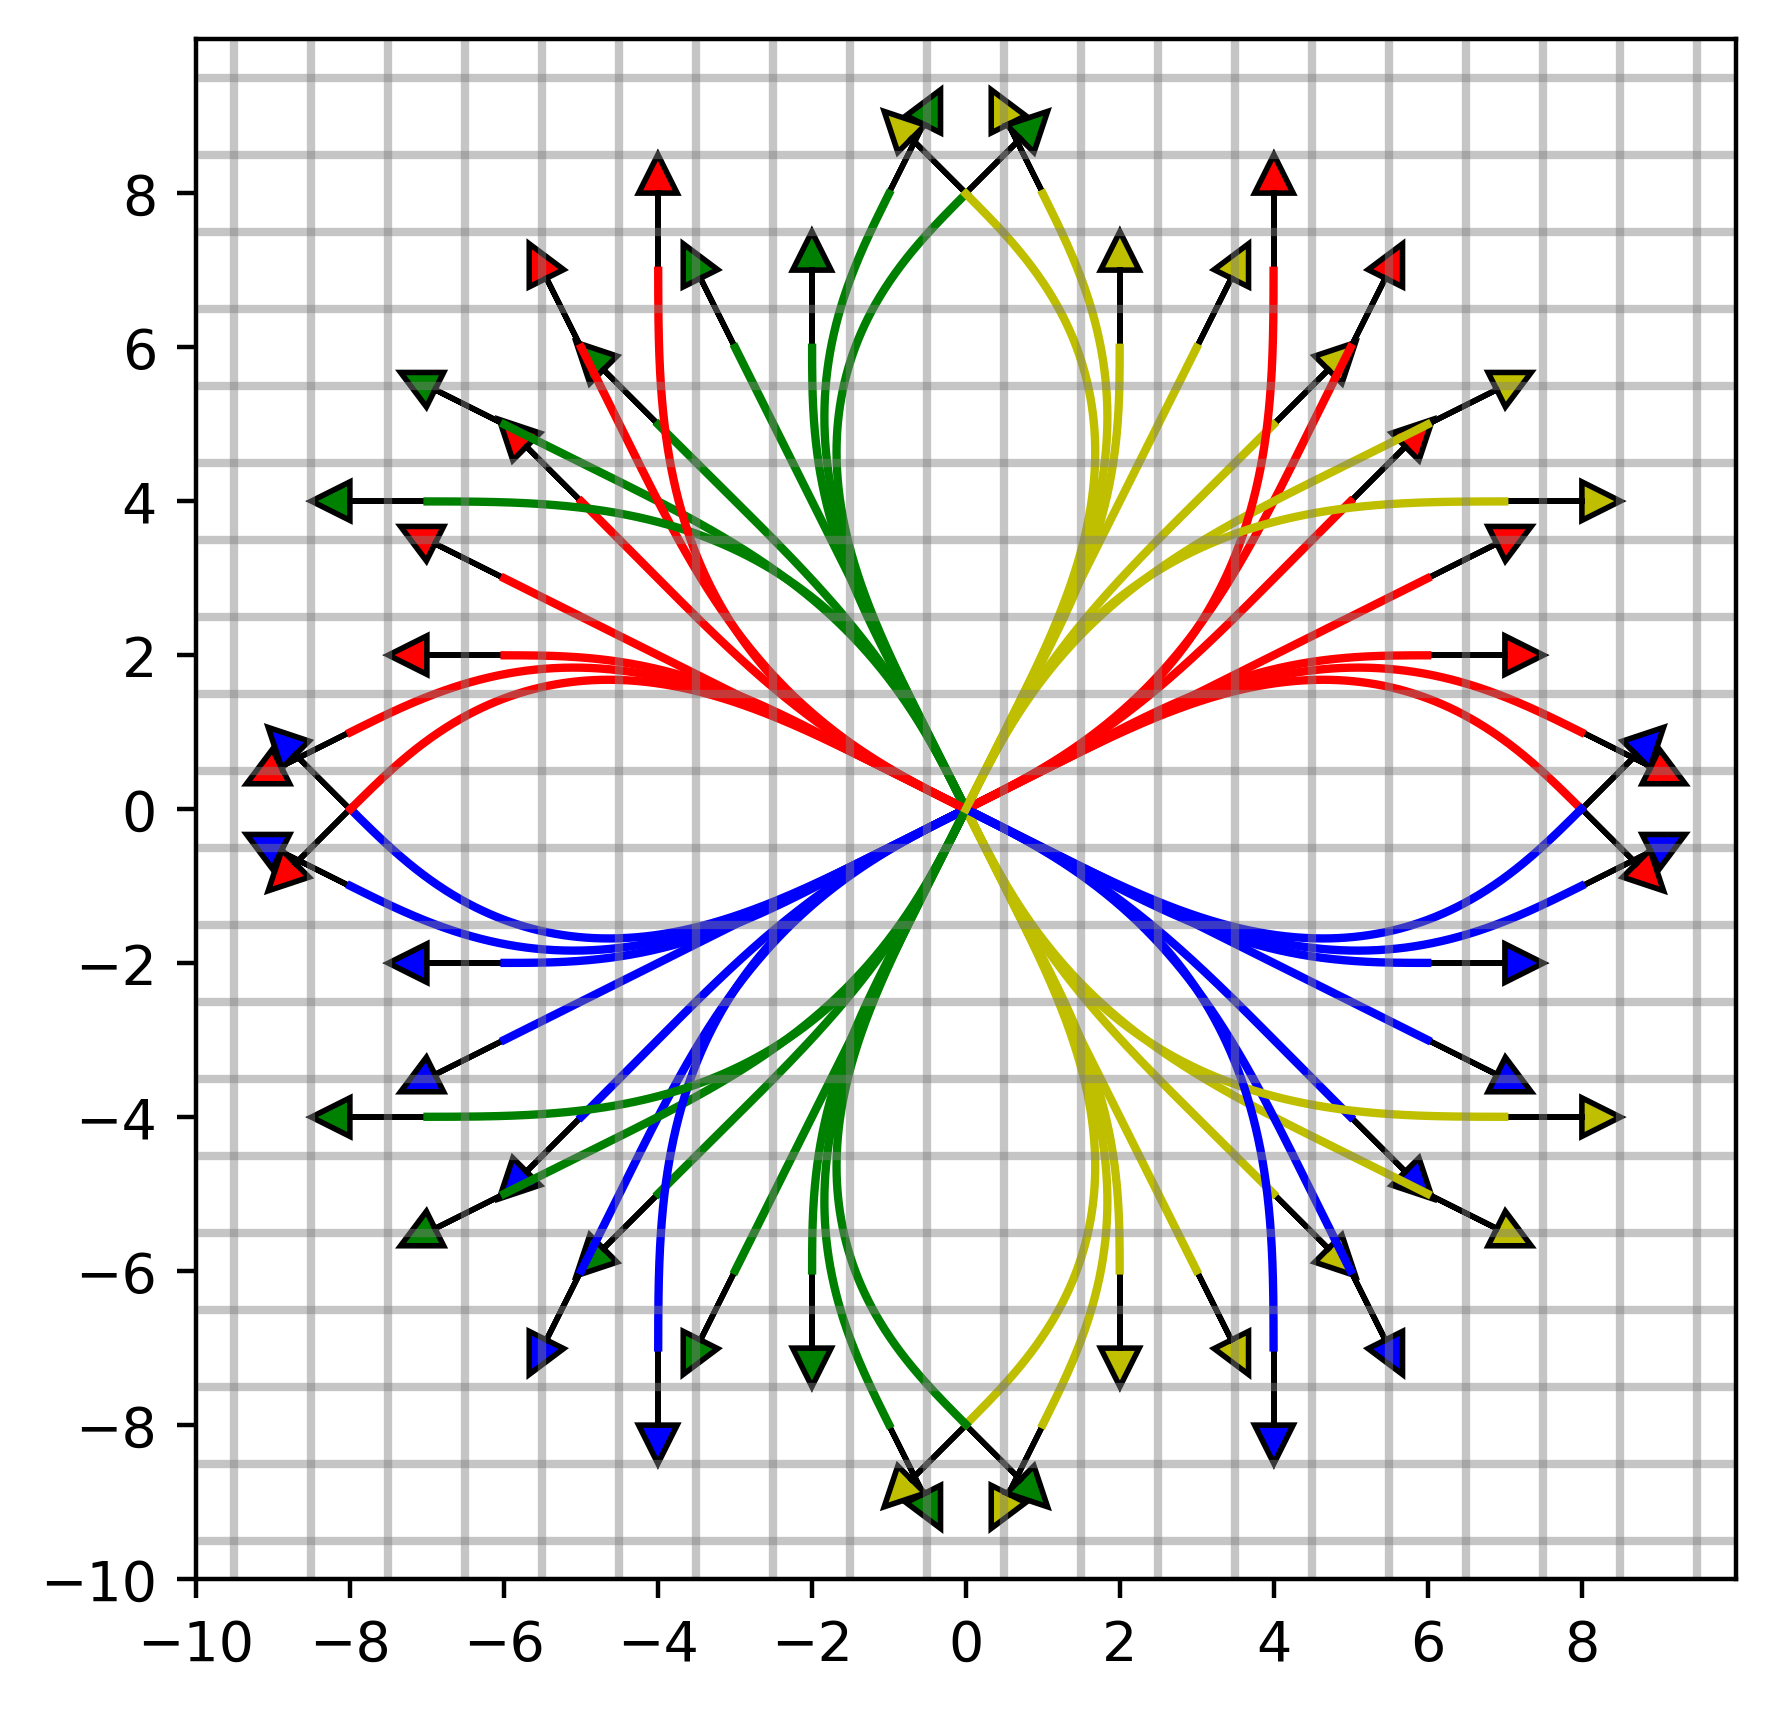

In [20]:
# 3. Generate primitives for the remaining 8 directions (e.g., arctan(1/2))
# Corresponds to index 1 in our 16-angle discretization

start = State(x=0, y=0, theta=theta_16[1])

fig = plt.figure(figsize=(5, 5), dpi=400)
ax = fig.add_subplot(111)
ax.set_aspect('equal', adjustable='box')

targets = [
    State(x=6.0, y=3.0, theta=theta_16[1]), # Straight-ish
    
    State(x=6.0, y=2.0, theta=theta_16[0]),
    State(x=8.0, y=1.0, theta=theta_16[-1]),
    State(x=8.0, y=0.0, theta=theta_16[-2]),
    
    State(x=5.0, y=4.0, theta=theta_16[2]),
    State(x=5.0, y=6.0, theta=theta_16[3]),
    State(x=4.0, y=7.0, theta=theta_16[4])
]

for target in targets:
    # 3a. Generate the base primitive
    steps, prim = optimization_Newton(start=start, goal=target)
    save_and_show(file=primitives_file, prim=prim, ax=ax, theta_discrete=theta_16)
    
    # 3b. Generate the symmetric primitive by reflecting across the Y-axis
    # This covers the angle index 7 (and its rotations via save_and_show)

    theta_diff = prim.goal.theta - prim.start.theta
    # Reflect start and goal states: theta becomes symmetric, x is negated
    new_start = State(0, 0, theta_16[7], -prim.k0)  # Curvature also becomes symmetric, but it is zero, so this doesnt't matter
    new_goal = State(-prim.goal.x, prim.goal.y, theta_16[7] - theta_diff)
    
    # Update primitive parameters
    prim.start = new_start
    prim.goal = new_goal
    prim.set_coef_params(-prim.a, -prim.b, -prim.c, prim.length)  # Curvature coefficients must be negated because the turn direction is flipped
    
    save_and_show(file=primitives_file, prim=prim, ax=ax, theta_discrete=theta_16)

draw_grid(ax, xs=-10, ys=-10, xf=10, yf=10, tick_step=2)

# plt.savefig("../../images/add_cs2.png", transparent=False, facecolor='white')
plt.show()